### Defino las funciones

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

import re
import random

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Limpieza del texto
from utils import desarmar_lista

[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
def z_score_monroe(DataFrame, variable_clase, variable_contenido, smoth_alpha, preprocessor, min_df, stop_words):  
    
    X = DataFrame[variable_contenido]
    y = DataFrame[variable_clase]

    #cuenta las ocurrencia de token
    count_vect = CountVectorizer(preprocessor=preprocessor, min_df = min_df, stop_words=stop_words)
  #representacion optimizada de la matriz termino-documento (que en este caso sería termino-clase)
    X_train = count_vect.fit_transform(X)
  #guardo el vocabulario
    vocabulario = pd.DataFrame(count_vect.vocabulary_.keys(),  index=count_vect.vocabulary_.values(), columns=['termino'])
  #utilizo el clasificador de naive bayes si bien no se predice nada porque tiene unos atributos que  realiza unos calculos que utilizo
    clf = MultinomialNB(alpha=smoth_alpha)
    clf.fit(X_train, y)
  # feature_log_prob_ Empirical log probability of features given a class, P(x_i|y).
    #log_pro = clf.feature_log_prob_
    log_pro=np.log(np.divide(clf.feature_count_+ smoth_alpha, (clf.feature_count_.sum(axis=1) + clf.feature_count_.shape[1]*smoth_alpha).reshape(2,1)- (clf.feature_count_+ smoth_alpha)))
  #calculo lo que seria algo asi como el log ods ratio Ecuacion 16 de Monroe et al 2009
    log_odds_ratio = (-1)*log_pro[0]-log_pro[1]*(-1)
  #calculo la varianza Ecuacion 20
    varianza = 1 / (clf.feature_count_[0] + smoth_alpha)  + 1 / (clf.feature_count_[1] + smoth_alpha)
  #calculo el z-score 22
    z_score_monroe= np.divide(log_odds_ratio, np.sqrt(varianza))
  #lo paso a data frame
    z_score = pd.DataFrame( z_score_monroe, columns= ['z_score_monroe'])
  #joineo con el vocabulario
    palabras_z_score = pd.concat([vocabulario, z_score], axis=1, join='inner')
    
    palabras_z_score['frecuencia'] = clf.feature_count_[0] + clf.feature_count_[1]
      
  #devuelve data frame con termino - z_score_monroe
    return(palabras_z_score)



In [4]:
#eje x ranking segun valor absoluto del z-score
def plot_z_score(z_score_df, n_palabras, titulo):
    from matplotlib.pyplot import figure
    df = pd.concat([z_score_df.nlargest(n_palabras, 'z_score_monroe'), z_score_df.nsmallest(n_palabras, 'z_score_monroe')], ignore_index=True)
    df['pos'] =df.z_score_monroe.abs().rank()
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax1 = plt.axes()
    ax1.axes.get_xaxis().set_visible(False)
    p1=sns.regplot(data=df, x="pos", y="z_score_monroe", fit_reg=False, marker="o", color="skyblue")
    for line in range(0,df.shape[0]):
        if df.z_score_monroe[line]<0:
            p1.text(df.pos[line]+0.2, df.z_score_monroe[line], df.termino[line], horizontalalignment='left', size='medium', color='black', rotation=45)
        else:
            p1.text(df.pos[line]-0.2, df.z_score_monroe[line], df.termino[line], horizontalalignment='right', size='medium', color='black', rotation=-45)
    p1.set_title(titulo)

In [5]:
#eje x frecuencia de cada palabra en escala logaritmica
def plot_z_score2(z_score_df, n_palabras, titulo):
    from matplotlib.pyplot import figure
    df = pd.concat([z_score_df.nlargest(n_palabras, 'z_score_monroe'), z_score_df.nsmallest(n_palabras, 'z_score_monroe')], ignore_index=True)
    #df['pos'] =df.z_score_monroe.abs().rank()
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax1 = plt.axes()
    ax1.set_xscale('log')
    p1=sns.regplot(data=df, x="frecuencia", y="z_score_monroe", fit_reg=False, marker="o", color="skyblue")
    for line in range(0,df.shape[0]):
        p1.text(df.frecuencia[line]+0.2, df.z_score_monroe[line], df.termino[line], horizontalalignment='left', size='medium', color='black')
    p1.set_title(titulo)

### Cargo bases

In [6]:
lang = "english"

In [7]:
#cargo bases 
df = pd.read_csv(f'data/{lang}_data.csv')



## Análisis con Z-Score de Monroe

In [8]:
stoplist = stopwords.words(lang)

specifict_stoplist = ['num', 'go', 'get', 'take', 'one']
stoplist = stoplist + specifict_stoplist

### Genero plot para la muestra en general

In [9]:
import time
t0 = time.time()
ZScore = z_score_monroe(df, 'target', 'text_norm', 1, None, 10, stoplist)
t1 = time.time()
print('Took', (t1 - t0)/60, 'minutes')


Took 0.005190714200337728 minutes


In [10]:
ZScore.to_csv(f'data/palabras_divisorias/palabras_divisorias_{lang}.csv', index=False)

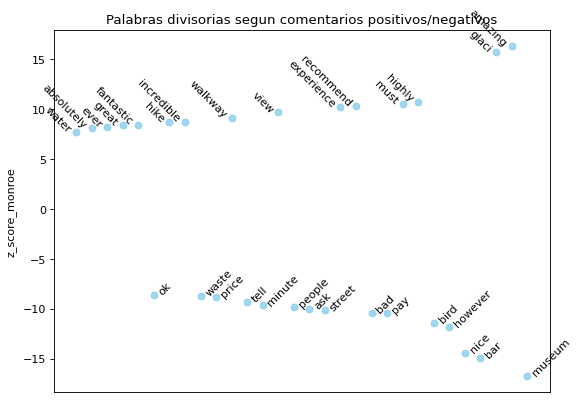

In [11]:
plot_z_score(ZScore, 15, 'Palabras divisorias segun comentarios positivos/negativos')

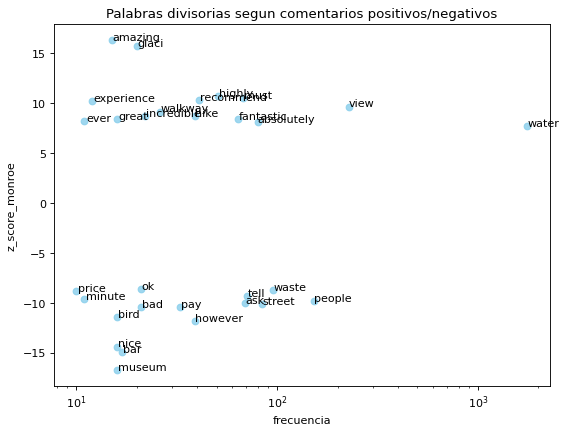

In [12]:
plot_z_score2(ZScore, 15, 'Palabras divisorias segun comentarios positivos/negativos')

### genero plot segun categoria

/home/vscode/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/home/vscode/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in subtract


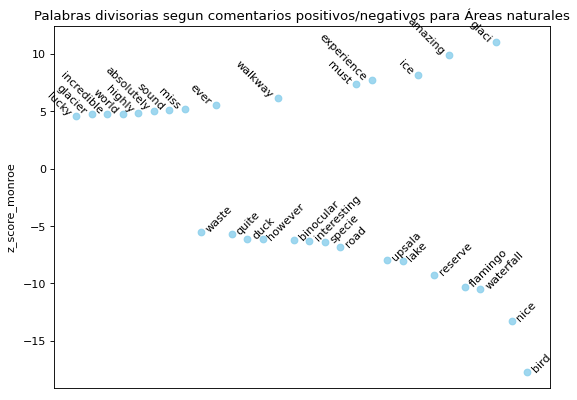

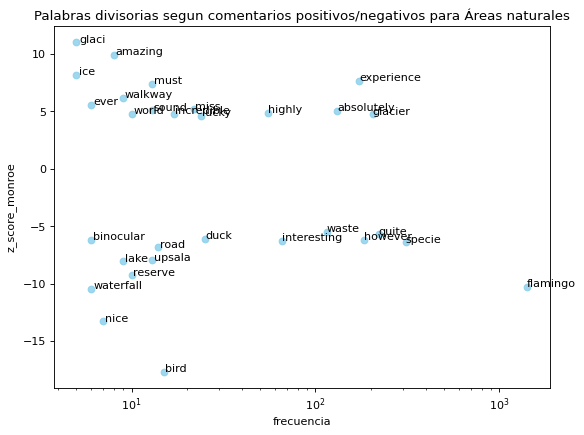

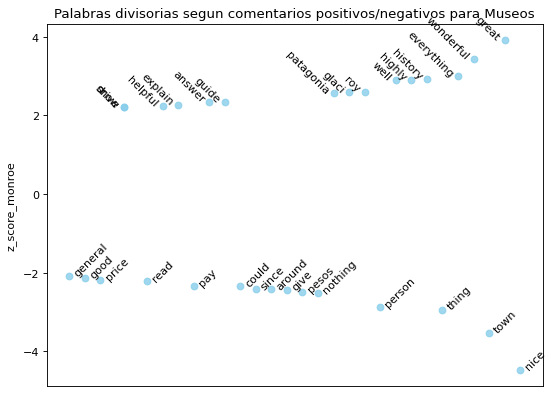

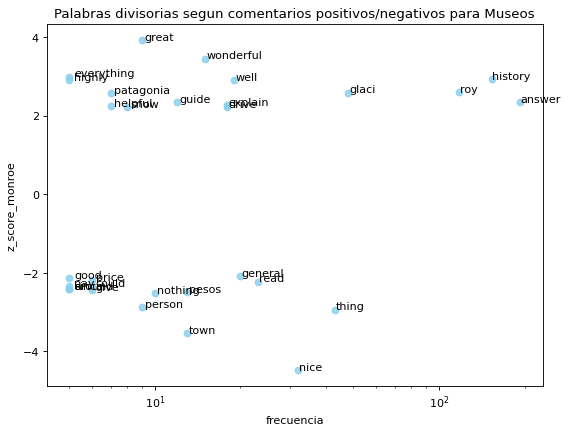

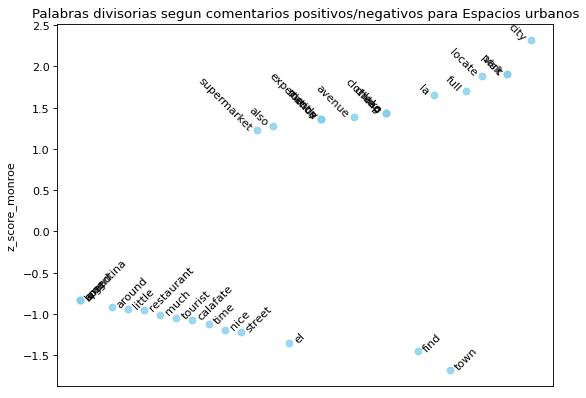

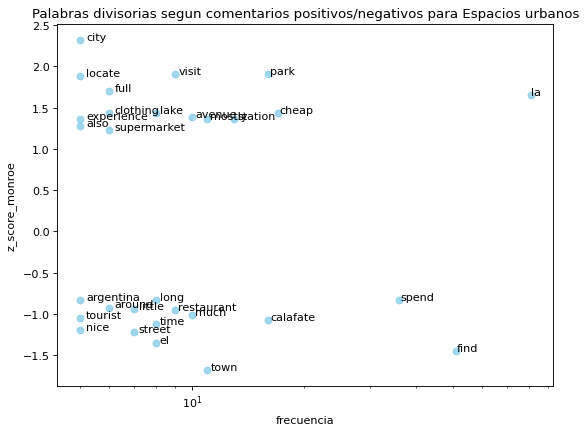

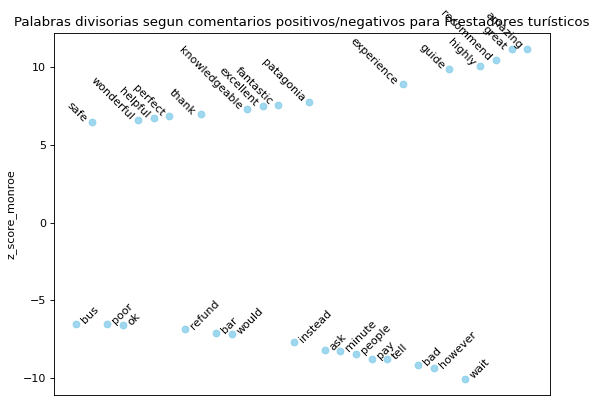

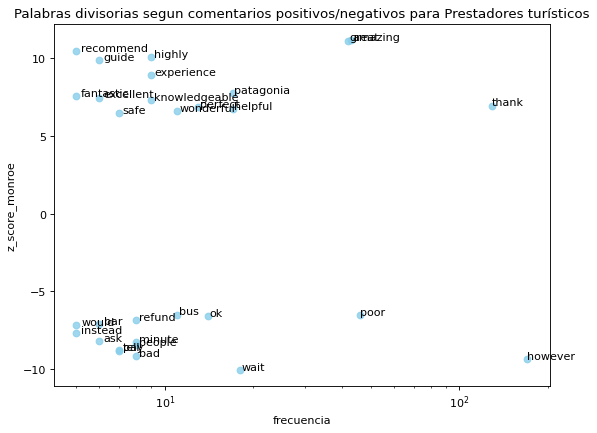

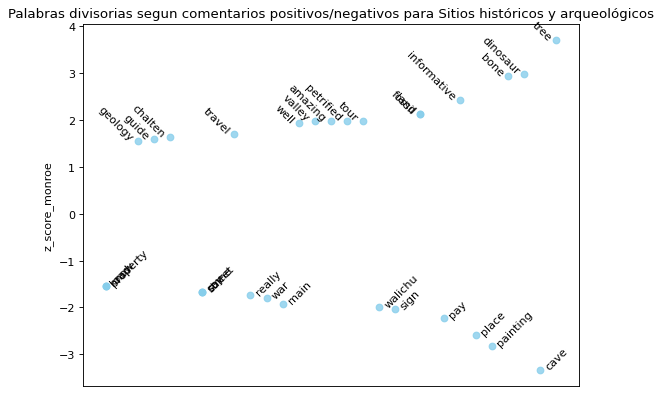

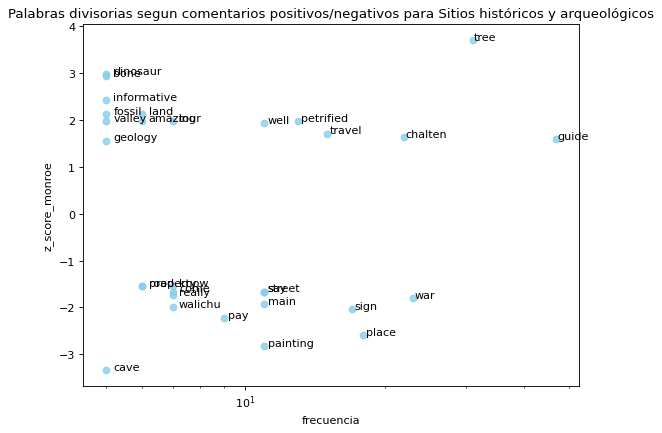

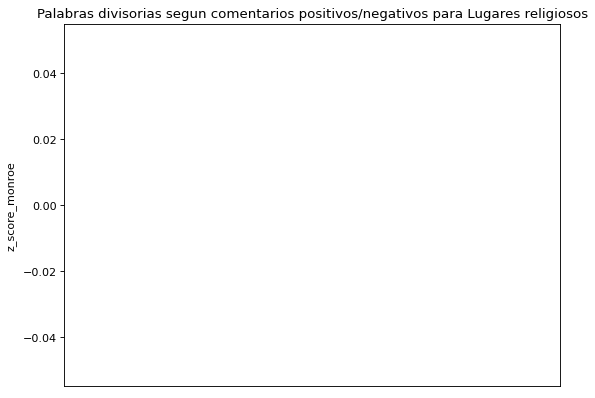

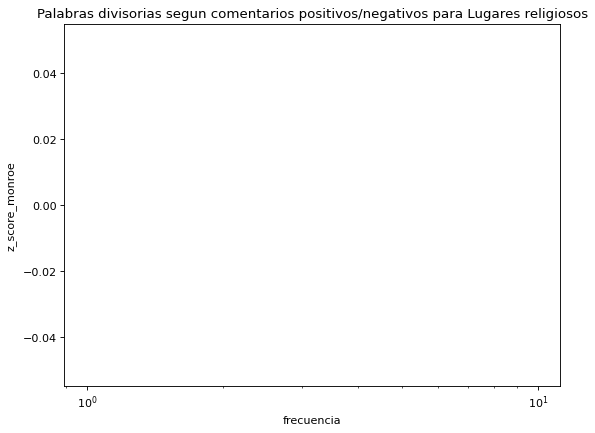

In [14]:
for cat in list(set(df.categoria_souldata)):
    ZScore = z_score_monroe(df.loc[df.categoria_souldata == cat], 'target', 'text_norm', 1, None, 5, stoplist)
    ZScore.to_csv(f'data/palabras_divisorias/palabras_divisorias_{lang}_{cat}.csv', index=False)
    plot_z_score(ZScore, 15, f'Palabras divisorias segun comentarios positivos/negativos para {cat}')
    plot_z_score2(ZScore, 15,  f'Palabras divisorias segun comentarios positivos/negativos para {cat}')